In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

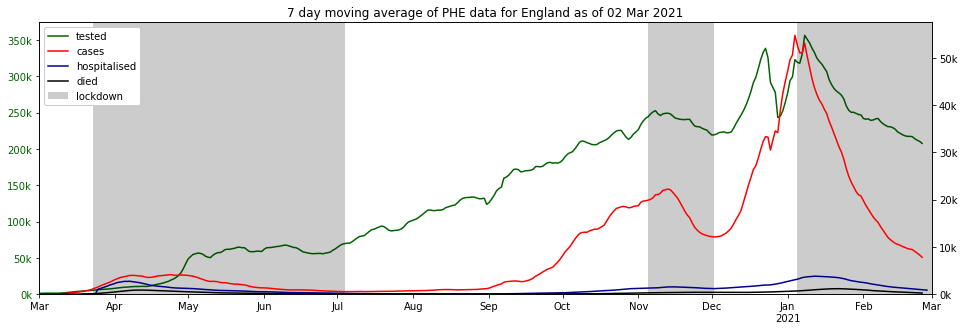

In [2]:
plot_summary(earliest_date='2020-03-01')

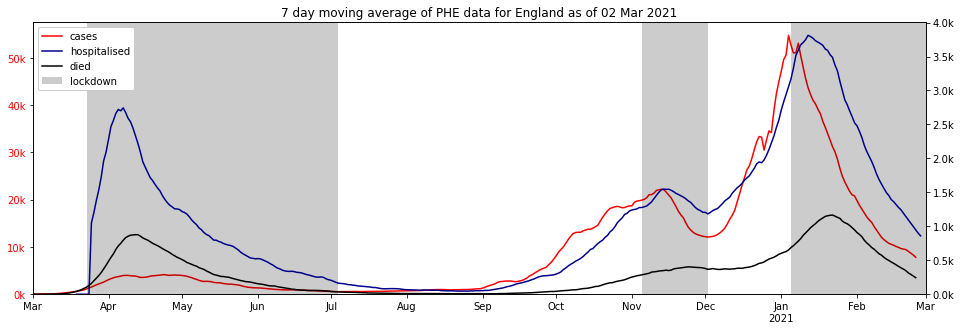

In [3]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,612567.0,17373384.0,16760817.0,56286961,1.088293,29.777442,69.134265
1,Northern Ireland,N92000002,35370.0,537389.0,502019.0,1893667,1.867805,26.510416,71.621779
2,Scotland,S92000003,84445.0,1634361.0,1549916.0,5463300,1.545678,28.369593,70.084729
3,Wales,W92000004,111716.0,933485.0,821769.0,3152879,3.543301,26.064083,70.392616


'partial: 20,478,619, full: 844,098'

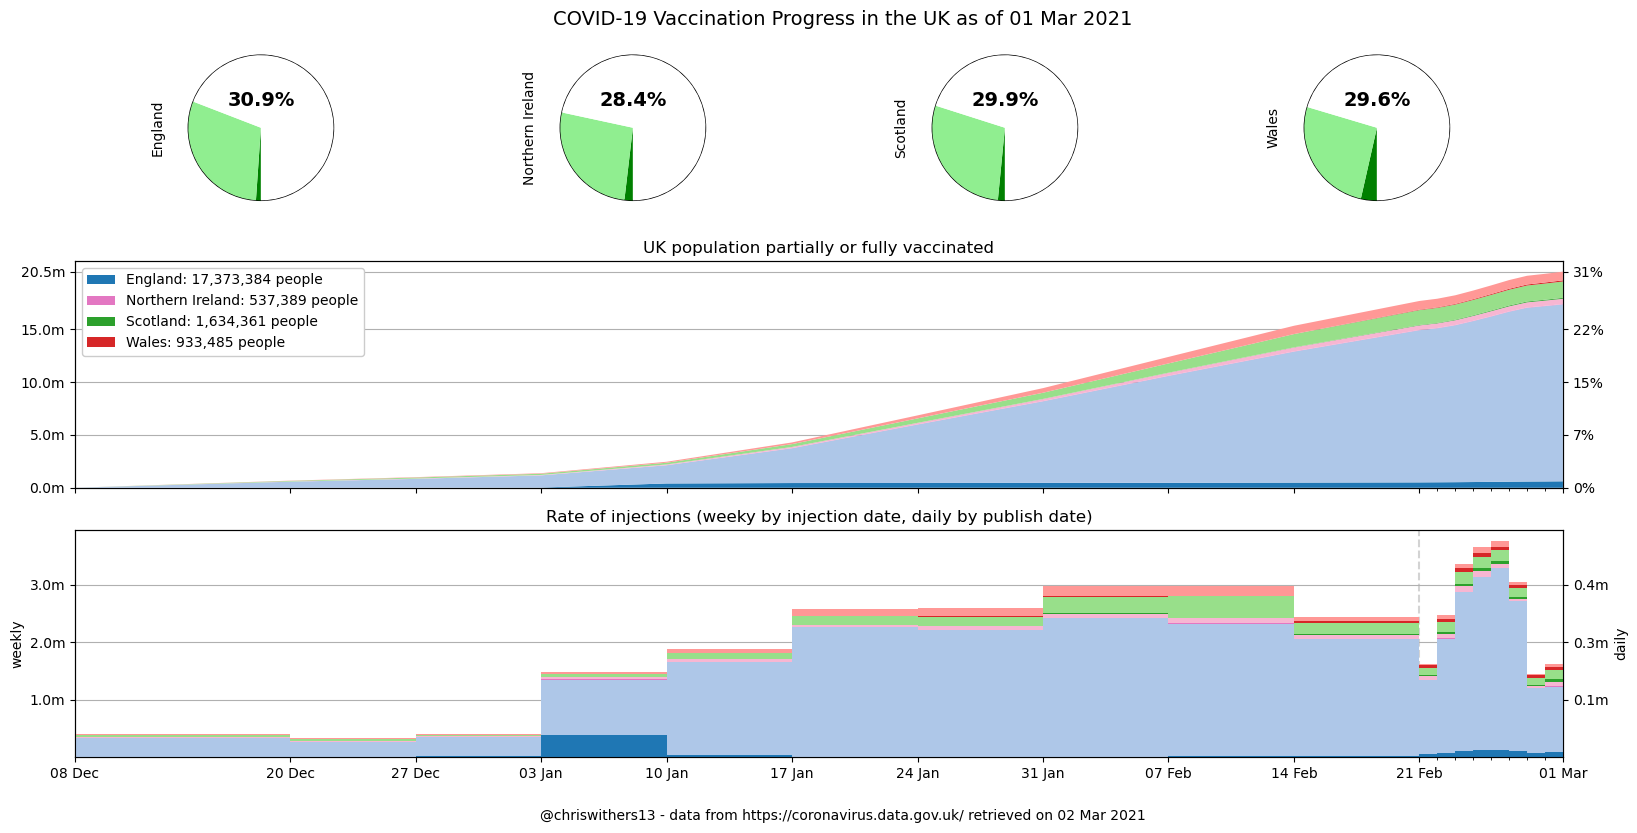

In [18]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}, full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,01 Mar 21,"+160,580","+12,632","+12,632","+17,373,384","+612,567","+612,567"
Northern Ireland,01 Mar 21,"+11,989","+2,173","+2,173","+537,389","+35,370","+35,370"
Scotland,01 Mar 21,"+22,783","+5,580","+5,580","+1,634,361","+84,445","+84,445"
Wales,01 Mar 21,"+7,816","+7,897","+7,897","+933,485","+111,716","+111,716"


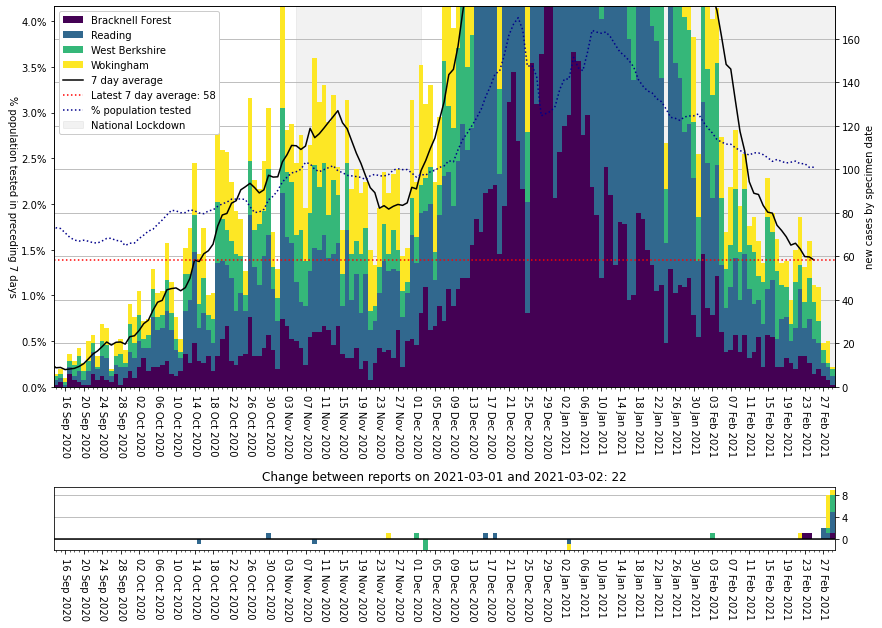

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=175)

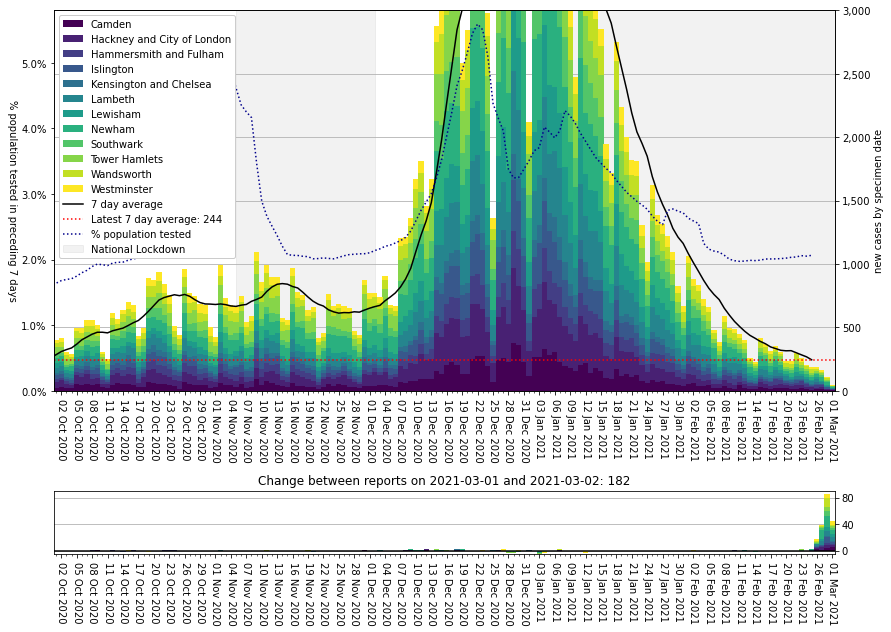

In [7]:
plot_areas(for_date, areas=london_areas, ylim=3_000)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000016,Leicester,153.857446,545.0,2021-03-01
E06000031,Peterborough,148.819088,301.0,2021-03-01
E07000150,Corby,146.777812,106.0,2021-03-01
E07000134,North West Leicestershire,146.702570,152.0,2021-03-01
E07000140,South Holland,141.024427,134.0,2021-03-01
E07000010,Fenland,139.420717,142.0,2021-03-01
E07000236,Redditch,137.225695,117.0,2021-03-01
E08000016,Barnsley,133.270681,329.0,2021-03-01
S12000014,Falkirk,132.388588,213.0,2021-03-01


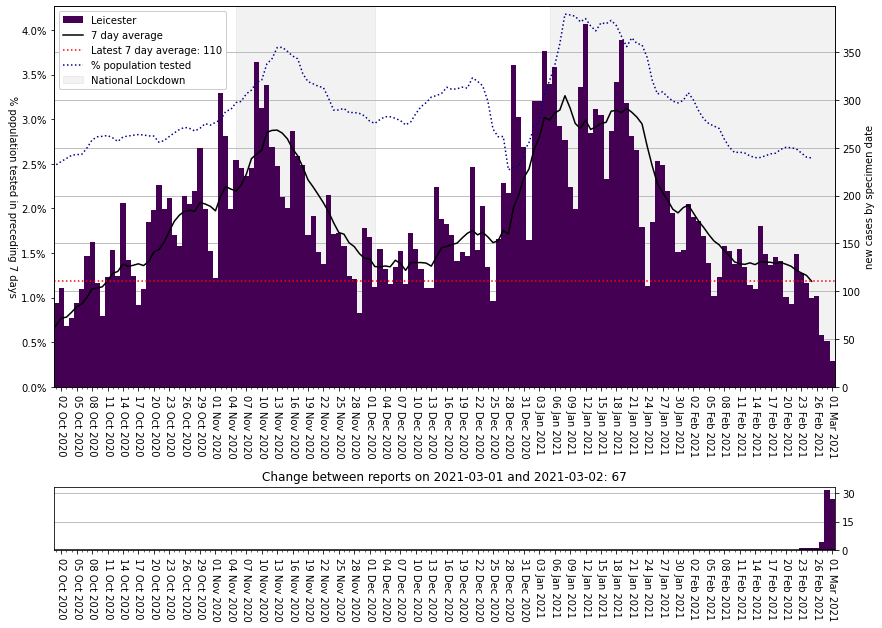

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,92.746993,1059.0,2021-03-01
E08000035,Leeds,106.790865,847.0,2021-03-01
E08000032,Bradford,126.719232,684.0,2021-03-01
S12000049,Glasgow City,93.663129,593.0,2021-03-01
E06000016,Leicester,153.857446,545.0,2021-03-01
E08000003,Manchester,89.715623,496.0,2021-03-01
E08000034,Kirklees,105.505620,464.0,2021-03-01
E08000019,Sheffield,79.165192,463.0,2021-03-01
E06000047,County Durham,85.645187,454.0,2021-03-01


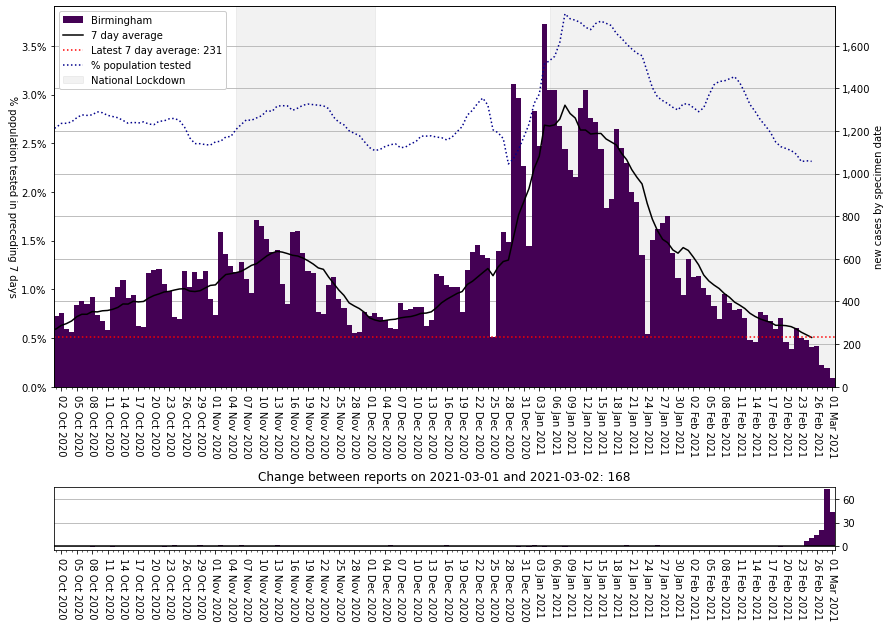

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.3
phe_max = 0.30

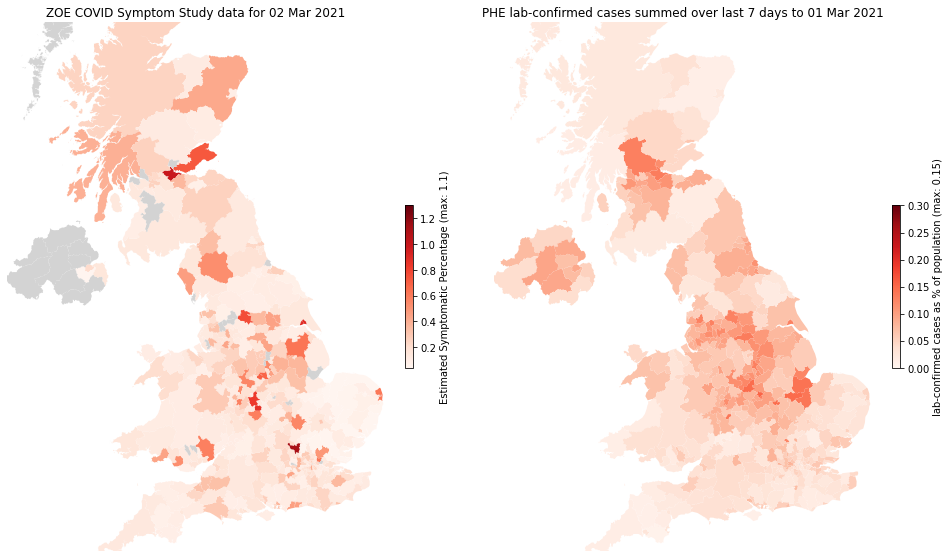

In [14]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [15]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

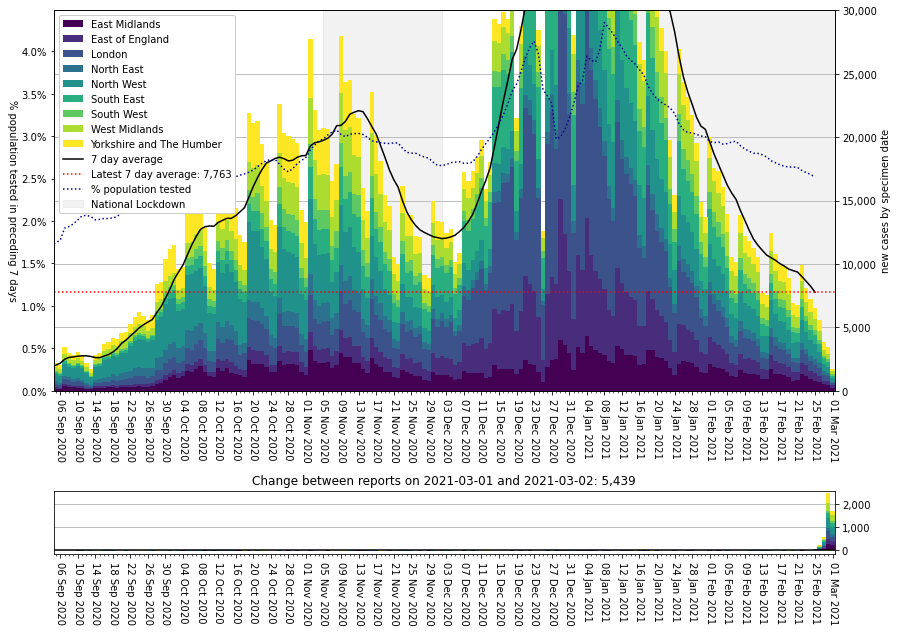

In [16]:
plot_areas(for_date, area_type=region, ylim=30_000, earliest='2020-09-05')

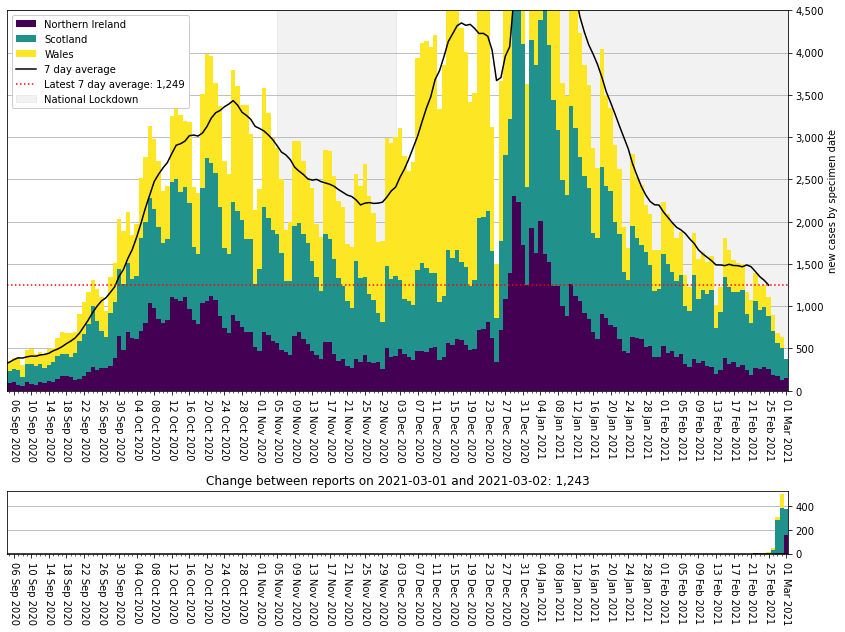

In [17]:
plot_areas(for_date, 'cases_devolved', ylim=4_500, diff_ylims=None, earliest='2020-09-05')